In [379]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import datetime as dt

Import Data

In [380]:
#import data

df = pd.read_csv("data\produkt_tu_stunde_19480101_20211231_05906.txt", delimiter=';')
df

,STATIONS_ID,MESS_DATUM,QN_9,TT_TU,RF_TU,eor
0,5906,1948010101,5,-0.3,90.0,eor
1,5906,1948010102,5,-0.3,89.0,eor
2,5906,1948010103,5,0.1,89.0,eor
3,5906,1948010104,5,0.5,91.0,eor
4,5906,1948010105,5,0.8,87.0,eor
...,...,...,...,...,...,...
648607,5906,2021123119,3,10.2,91.0,eor
648608,5906,2021123120,3,10.9,88.0,eor
648609,5906,2021123121,3,11.0,88.0,eor
648610,5906,2021123122,3,11.1,88.0,eor


Clean & harmonize data set

In [381]:
#remove unneeded data

df=df.drop(columns=['STATIONS_ID', 'QN_9', 'eor'])
df.head(2)

,MESS_DATUM,TT_TU,RF_TU
0,1948010101,-0.3,90.0
1,1948010102,-0.3,89.0


In [382]:
#rename MESS_DATUM in Date

df = df.rename(columns={"MESS_DATUM": "Date"})

In [383]:
#convert int to date

df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d%H')
df.head(2)

,Date,TT_TU,RF_TU
0,1948-01-01 01:00:00,-0.3,90.0
1,1948-01-01 02:00:00,-0.3,89.0


In [384]:
#only last 21 years

df=df[df['Date'].dt.year >= 2001]
df

,Date,TT_TU,RF_TU
464615,2001-01-01 00:00:00,-2.1,87.0
464616,2001-01-01 01:00:00,-2.1,87.0
464617,2001-01-01 02:00:00,-1.2,82.0
464618,2001-01-01 03:00:00,0.0,75.0
464619,2001-01-01 04:00:00,0.5,71.0
...,...,...,...
648607,2021-12-31 19:00:00,10.2,91.0
648608,2021-12-31 20:00:00,10.9,88.0
648609,2021-12-31 21:00:00,11.0,88.0
648610,2021-12-31 22:00:00,11.1,88.0


In [385]:
#remove leap years from dataset

df = df[~((df.Date.dt.month == 2) & (df.Date.dt.day == 29)) ]

In [386]:
#problem with -999 values

df.min()

Date     2001-01-01 00:00:00
TT_TU                   -999
RF_TU                   -999
dtype: object

In [387]:
#replace -999 values with nan

df = df.replace(-999, np.nan)
df.min()

Date     2001-01-01 00:00:00
TT_TU                  -17.9
RF_TU                     11
dtype: object

In [388]:
#count the nan values

df.apply(pd.isnull).sum()

Date       0
TT_TU    151
RF_TU    164
dtype: int64

In [389]:
#fill the nan values with the values forwoard

df=df.ffill(axis = 0)
df.apply(pd.isnull).sum()


Date     0
TT_TU    0
RF_TU    0
dtype: int64

In [390]:
#min and max values from each day

#new dataframe
df['Date'] = pd.to_datetime(df['Date']).dt.date
df2 = pd.DataFrame(columns= ["Date"])

#get min & max values
df2["min_TT_TU"] = df.groupby(["Date"])["TT_TU"].min()
df2["max_TT_TU"] = df.groupby(["Date"])["TT_TU"].max()
df2["min_RF_TU"] = df.groupby(["Date"])["RF_TU"].min()
df2["max_RF_TU"] = df.groupby(["Date"])["RF_TU"].max()

#reset the index of df2
df2['Date'] = df2.index
df2 = df2.reset_index(drop=True)

#convert "Date" from object to date
df2['Date'] = pd.to_datetime(df2['Date'])

df2

,Date,min_TT_TU,max_TT_TU,min_RF_TU,max_RF_TU
0,2001-01-01,-2.1,3.1,69.0,87.0
1,2001-01-02,1.9,8.5,81.0,90.0
2,2001-01-03,1.9,8.3,73.0,90.0
3,2001-01-04,2.4,8.3,74.0,90.0
4,2001-01-05,6.6,11.1,75.0,89.0
...,...,...,...,...,...
7658,2021-12-27,3.2,10.4,79.0,100.0
7659,2021-12-28,7.7,11.0,74.0,98.0
7660,2021-12-29,8.7,10.7,76.0,99.0
7661,2021-12-30,11.0,15.1,81.0,98.0


Data set label & split

In [413]:
#create labeled data set for predictions in one day or 2 Weeks (2 week = 14 days)

prediction_days = (7)
df2["Prediction_min_TT"]=df2["min_TT_TU"].shift(-prediction_days)
df2["Predictionmax_TT"]=df2["max_TT_TU"].shift(-prediction_days)

df2

,Date,min_TT_TU,max_TT_TU,min_RF_TU,max_RF_TU,Prediction_min_TT,Predictionmax_TT
0,2001-01-01,-2.1,3.1,69.0,87.0,-0.8,5.4
1,2001-01-02,1.9,8.5,81.0,90.0,0.2,5.0
2,2001-01-03,1.9,8.3,73.0,90.0,-1.0,5.4
3,2001-01-04,2.4,8.3,74.0,90.0,3.6,6.3
4,2001-01-05,6.6,11.1,75.0,89.0,-1.3,4.7
...,...,...,...,...,...,...,...
7658,2021-12-27,3.2,10.4,79.0,100.0,NaN,NaN
7659,2021-12-28,7.7,11.0,74.0,98.0,NaN,NaN
7660,2021-12-29,8.7,10.7,76.0,99.0,NaN,NaN
7661,2021-12-30,11.0,15.1,81.0,98.0,NaN,NaN


In [414]:
#split the data in x und y axis

X = np.array(df2[["min_TT_TU"]])
X = X[: len(df2)-prediction_days]

In [415]:
#create y values

y = np.array(df2["Prediction_min_TT"])
y = y[:-prediction_days]

In [416]:
#aufteilen der Daten in Trainings und Test Daten

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [417]:
#erstellen einer varaible mit letzten 365*24 Werten aus dem df

prediction_days_array = np.array(df2[['min_TT_TU']])[-prediction_days:]

Support Vector Regression

In [418]:
#from sklearn.svm import SVR

#Support Vector Regression mit radial basis function

svr_rbf = SVR(kernel="rbf", C=1e3, gamma=0.1)
svr_rbf.fit(X_train, y_train)

SVR(C=1000.0, gamma=0.1)

In [419]:
#Testen des Models

model_test = svr_rbf.score(X_test, y_test)
print("Model Score: ", model_test)

Model Score:  0.5623874860400988


In [432]:
svm_prediction = svr_rbf.predict(prediction_days_array)
print(svm_prediction)

print()


print(df2["min_TT_TU"].tail(prediction_days))

[ 2.86020977  2.35494018  3.18679055  7.63020849  8.51327452 11.09977434
  8.9645964 ]

7656     2.7
7657     1.6
7658     3.2
7659     7.7
7660     8.7
7661    11.0
7662     9.4
Name: min_TT_TU, dtype: float64


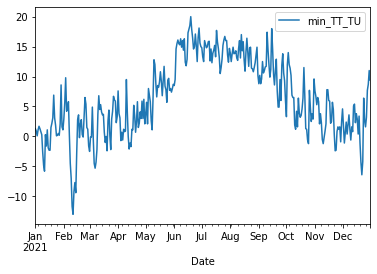

In [434]:
import matplotlib.pyplot as plt
df3=df2[df2['Date'].dt.year >= 2021]
df3.plot(x="Date", y=["min_TT_TU"], kind="line")